In [1]:
#Mounting Drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
#importing basic important libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [3]:
#Read the dataset
df = pd.read_csv(r'/content/drive/MyDrive/FY_Project/OLIDv1.0/train_dataset.tsv',sep="\t") 

In [4]:
#10 rows of dataset
df.head(10)

,id,tweet,subtask_a,subtask_b,subtask_c
0,86426,@USER She should ask a few native Americans wh...,OFF,UNT,NaN
1,90194,@USER @USER Go home you’re drunk!!! @USER #MAG...,OFF,TIN,IND
2,16820,Amazon is investigating Chinese employees who ...,NOT,NaN,NaN
3,62688,"@USER Someone should'veTaken"" this piece of sh...",OFF,UNT,NaN
4,43605,@USER @USER Obama wanted liberals &amp; illega...,NOT,NaN,NaN
5,97670,@USER Liberals are all Kookoo !!!,OFF,TIN,OTH
6,77444,@USER @USER Oh noes! Tough shit.,OFF,UNT,NaN
7,52415,@USER was literally just talking about this lo...,OFF,TIN,GRP
8,45157,@USER Buy more icecream!!!,NOT,NaN,NaN
9,13384,@USER Canada doesn’t need another CUCK! We alr...,OFF,TIN,IND


In [5]:
#1st column is id.
#2nd column is the tweet text.
#3rd column is first level classification of tweets into Offensive(OFF) and Not-Offensive(NOT).
#4th column is second level classification of Offensive tweets into targetted(TIN) tweets and untargetted(UNT), rest non-offensive tweets as NaN.
#5th column is third level classification of Targetted tweets into Individual(IND) targetted, Group(GRP) targetted and Others(OTH), rest non-offensive or non-targetted tweets as NaN.

In [6]:
#shape of data
df.shape

(13240, 5)

In [7]:
#delete id column as it does not take part in training
del df["id"]

In [8]:
#install contractions library file
!pip install contractions

     |████████████████████████████████| 286kB 6.9MB/s 
     |████████████████████████████████| 327kB 15.1MB/s 
  Created wheel for pyahocorasick: filename=pyahocorasick-1.4.2-cp37-cp37m-linux_x86_64.whl size=85388 sha256=e8d431280faa66ce3f426ed5efd2075b9039dba64ad78ec073e38a477767802c
  Stored in directory: /root/.cache/pip/wheels/3a/03/34/77e3ece0bba8b86bfac88a79f923b36d805cad63caeba38842
Successfully built pyahocorasick


In [9]:
#importing required libraries
import nltk
import inflect
import contractions
from bs4 import BeautifulSoup
import re, string, unicodedata
from nltk import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer

In [10]:
# First function is used to denoise text
def denoise_text(text):
    # Strip html if any. For ex. removing <html>, <p> tags
    soup = BeautifulSoup(text, "html.parser")
    text = soup.get_text()
    # Replace contractions in the text. For ex. didn't -> did not
    text = contractions.fix(text)
    return text
# Checking the function 
sample_text = "<p>he didn't say anything </br> about what's gonna <html> happen in the climax"
denoise_text(sample_text)

'he did not say anything  about what is going to  happen in the climax'

In [11]:
# Text normalization includes many steps.
# Each function below serves a step.

# Gets rid of the non ASCII characters
def remove_non_ascii(words):
    new_words = []
    for word in words:
        new_word = unicodedata.normalize('NFKD', word).encode('ascii', 'ignore').decode('utf-8', 'ignore')
        new_words.append(new_word)
    return new_words

# Converts the entire text to lowercase
def to_lowercase(words):
    new_words = []
    for word in words:
        new_word = word.lower()
        new_words.append(new_word)
    return new_words

# Removes the punctuation marks
def remove_punctuation(words):
    new_words = []
    for word in words:
        new_word = re.sub(r'[^\w\s]', '', word)
        if new_word != '':
            new_words.append(new_word)
    return new_words

# Numbers to their textual representation
def replace_numbers(words):
    p = inflect.engine()
    new_words = []
    for word in words:
        if word.isdigit():
            new_word = p.number_to_words(word)
            new_words.append(new_word)
        else:
            new_words.append(word)
    return new_words

# Removes stop words
def remove_stopwords(words):
    new_words = []
    for word in words:
        if word not in stopwords.words('english'):
            new_words.append(word)
    return new_words

# Lemmatizes verbs in the list of tokenized words
def lemmatize_verbs(words):
    lemmatizer = WordNetLemmatizer()
    lemmas = []
    for word in words:
        lemma = lemmatizer.lemmatize(word, pos='v')
        lemmas.append(lemma)
    return lemmas

#All above functions are put together
def normalize_text(words):
    words = remove_non_ascii(words)
    words = to_lowercase(words)
    words = remove_punctuation(words)
    words = replace_numbers(words)
    words = remove_stopwords(words)
    words = lemmatize_verbs(words)
    return words

In [12]:
# Downloading the necessary packages
nltk.download('punkt')
nltk.download('wordnet')
nltk.download('stopwords')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [13]:
# Tokenize tweet into words
def tokenize(text):
    return nltk.word_tokenize(text)
# Function check
sample_text = 'he did not say anything  about what is going to  happen'
print("tokenize results :", tokenize(sample_text))

tokenize results : ['he', 'did', 'not', 'say', 'anything', 'about', 'what', 'is', 'going', 'to', 'happen']


In [14]:
#Text Preparation to use them into model
def text_prepare(text):
    text = denoise_text(text)
    text = normalize_text(tokenize(text))
    return text
#Sample input text after text_prepare
text_prepare('he did not say anything  about what is going to  happen')

['say', 'anything', 'go', 'happen']

Level-1 classification starts here...

In [15]:
#X is the tweets
X=df['tweet']

In [16]:
#Level-1 classification labels are Offensive(OFF) and Non-Offensive(NOT)
#8840 tuples are Not-offensive and 4400 tuples are offensive
df["subtask_a"].value_counts()

NOT    8840
OFF    4400
Name: subtask_a, dtype: int64

In [17]:
#Y is labels for level-1 classification
Y = df["subtask_a"]
Y = (Y=="OFF").astype(int)
#encoding labels Not-offensive as 0 and offensive as 1
classes1=["NOT","OFF"]
(Y==0).sum(),(Y==1).sum()

(8840, 4400)

In [18]:
#Splitting into training and testing tuples
from sklearn.model_selection import train_test_split
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=2)
X_train.shape,Y_train.shape,X_test.shape,Y_test.shape

((10592,), (10592,), (2648,), (2648,))

In [19]:
#No. of offensive labelled tuples in training dataset
(Y_train==1).sum()

3526

In [20]:
#Resetting index in all of the tables
X_test=X_test.reset_index(drop=True)
Y_test=Y_test.reset_index(drop=True)
X_train=X_train.reset_index(drop=True)
Y_train=Y_train.reset_index(drop=True)

In [21]:
#Training Tweets
X_train.head()

0    @USER #Foolish Why because some #idiots are do...
1    @USER @USER Liberals have always wanted to get...
2    @USER @USER Liberals Demonuts will never learn...
3    @USER Woooow Trump voters are getting really c...
4    @USER So funny, this was labeled as sensitive ...
Name: tweet, dtype: object

In [22]:
#Labels of training tweets
Y_train.head()

0    1
1    0
2    0
3    1
4    1
Name: subtask_a, dtype: int64

In [23]:
#Import CountVectorizer Library for feature extraction
from sklearn.feature_extraction.text import CountVectorizer
tf1=CountVectorizer(analyzer=text_prepare,min_df=20,max_df=500)

In [24]:
#Fitting on training dataset and transforming dataset to get features in dataframe form
tf1.fit(X_train)

train_tf=tf1.transform(X_train)

X_train_tf=pd.DataFrame(train_tf.toarray(),columns=tf1.get_feature_names())

test_tf=tf1.transform(X_test)

X_test_tf=pd.DataFrame(test_tf.toarray(),columns=tf1.get_feature_names())

In [25]:
#Shape of transformed dataset
X_train_tf.shape,X_test_tf.shape

((10592, 895), (2648, 895))

In [26]:
X_train_tf.head()

,2a,2nd,able,abortion,absolutely,abuse,accept,accord,account,accusations,accuse,accuser,act,action,activist,actual,actually,add,address,admit,advocate,age,agenda,ago,agree,alive,allegations,allow,almost,alone,along,already,also,always,amaze,amendment,america,american,americans,another,...,ways,weapons,wear,week,weird,welcome,well,whatever,white,whole,wife,win,wing,wish,without,woman,women,wonder,wonderful,word,work,world,worry,worse,worst,worth,would,wow,write,wrong,wwg1wga,ya,yeah,year,years,yes,yet,young,yrs,zero
0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0


In [27]:
#importing SVM classifier model
from sklearn.svm import SVC
svm1=SVC(probability=True)

In [28]:
#Fitting training dataset over SVM model
svm1.fit(X_train_tf,Y_train)

SVC(C=1.0, break_ties=False, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='scale', kernel='rbf',
    max_iter=-1, probability=True, random_state=None, shrinking=True, tol=0.001,
    verbose=False)

In [29]:
#Predicting transformed testing dataset
Y_pred=svm1.predict(X_test_tf)

In [30]:
#Checking the shape of the Y_pred vector and the Y_test vector
Y_pred.shape,Y_test.shape

((2648,), (2648,))

(array([2296.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,
         352.]),
 array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ]),
 <a list of 10 Patch objects>)

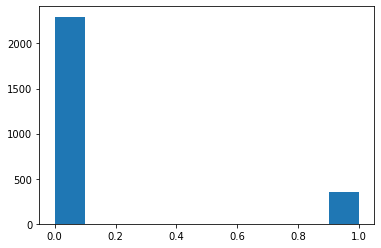

In [31]:
#Plotting histogram of Y_pred
plt.hist(Y_pred)

In [32]:
predicted=Y_pred                             #Predicted value
real=Y_test                                  #Real value
Precision_sum=0
Recall_sum=0
Accuracy_sum=0

for i in range(len(classes1)):
  print("For class :",classes1[i])
  TP=((predicted==i) & (real==i)).sum()        #True Positive
  TN=((predicted!=i) & (real!=i)).sum()        #True Negative
  FP=((predicted==i) & (real!=i)).sum()        #False Positive
  FN=((predicted!=i) & (real==i)).sum()        #False Negative

  P=TP+FN                                      #Positives(real)
  N=TN+FP                                      #Negatives(real)

  Total=P+N                                    #Total tuples

  #Calculating all metrices
  Accuracy=(TP+TN)/Total
  Accuracy_sum+=Accuracy
  Sensitivity=TP/P
  Specificity=TN/N
  Precision=TP/(TP+FP)
  Precision_sum+=Precision
  Recall=TP/P
  Recall_sum+=Recall
  KS=(TP/P)-(FP/N) 
  F1=2*Precision*Recall/(Precision+Recall)

  print("TP:",TP,"TN:",TN,"FP:",FP,"FN:",FN,"P:",P,"N:",N,"Total:",Total)
  print("Accuracy    =",Accuracy)
  print("Sensitivity =",Sensitivity)
  print("Specificity =",Specificity)
  print("Precision   =",Precision)
  print("Recall      =",Recall)
  print("KS          =",KS)
  print("F1          =",F1)
  print()

#Global
Precision=Precision_sum/len(classes1)
Recall=Recall_sum/len(classes1)
Accuracy=Accuracy_sum/len(classes1)
F1=2*Precision*Recall/(Precision+Recall)

print("Global Metrics:")
print("Accuracy    =",Accuracy)
print("Precision   =",Precision)
print("Recall      =",Recall)
print("F1          =",F1)

For class : NOT
TP: 1713 TN: 291 FP: 583 FN: 61 P: 1774 N: 874 Total: 2648
Accuracy    = 0.756797583081571
Sensitivity = 0.9656144306651635
Specificity = 0.3329519450800915
Precision   = 0.7460801393728222
Recall      = 0.9656144306651635
KS          = 0.298566375745255
F1          = 0.8417690417690418

For class : OFF
TP: 291 TN: 1713 FP: 61 FN: 583 P: 874 N: 1774 Total: 2648
Accuracy    = 0.756797583081571
Sensitivity = 0.3329519450800915
Specificity = 0.9656144306651635
Precision   = 0.8267045454545454
Recall      = 0.3329519450800915
KS          = 0.298566375745255
F1          = 0.4747145187601957

Global Metrics:
Accuracy    = 0.756797583081571
Precision   = 0.7863923424136838
Recall      = 0.6492831878726275
F1          = 0.7112907007604347


In [33]:
from sklearn.metrics import classification_report
print(classification_report(real,predicted,target_names=classes1))

              precision    recall  f1-score   support

         NOT       0.75      0.97      0.84      1774
         OFF       0.83      0.33      0.47       874

    accuracy                           0.76      2648
   macro avg       0.79      0.65      0.66      2648
weighted avg       0.77      0.76      0.72      2648



In [34]:
#Predicting ith instance of testing dataset
i=2
X_test[i],classes1[Y_pred[i]],classes1[Y_test[i]]

('@USER Y’all need to know that she is human being and knew Mac for so many years and was in a relationship with him. She’s grieving. She doesn’t have post something to prove that. AND IT IS NOT HER FAULT HE DIED LIKE DAMN! Stop blaming this poor girl. His addiction killed him.',
 'OFF',
 'OFF')

In [35]:
#Predicting tweets
instance = df['tweet'][1]
print(instance)

instance_tf = tf1.transform([instance])
instance_tf_pd=pd.DataFrame(instance_tf.toarray(),columns=tf1.get_feature_names())
pred=svm1.predict(instance_tf_pd)

classes1[pred[0]],df['subtask_a'][1]

@USER @USER Go home you’re drunk!!! @USER #MAGA #Trump2020 👊🇺🇸👊 URL


('NOT', 'OFF')

**2nd** level classification starts here...

In [36]:
#Dataset import
df2=df.loc[df["subtask_b"].notnull()]
df2.reset_index(inplace=True,drop=True)

In [37]:
#Sample data
df2.head()

,tweet,subtask_a,subtask_b,subtask_c
0,@USER She should ask a few native Americans wh...,OFF,UNT,NaN
1,@USER @USER Go home you’re drunk!!! @USER #MAG...,OFF,TIN,IND
2,"@USER Someone should'veTaken"" this piece of sh...",OFF,UNT,NaN
3,@USER Liberals are all Kookoo !!!,OFF,TIN,OTH
4,@USER @USER Oh noes! Tough shit.,OFF,UNT,NaN


In [38]:
#Shape of the dataset
df2.shape

(4400, 4)

In [39]:
#Class counts
df2["subtask_b"].value_counts()

TIN    3876
UNT     524
Name: subtask_b, dtype: int64

In [40]:
#The input features for the level 2 classification
X=df2["tweet"]

In [41]:
#Y is the output class with value of 0 if it is untargeted else 1
Y=df2['subtask_b'].apply(lambda x: 0 if x =='UNT' else 1)
#2 classes at level 2
classes2=["UNT","TIN"]
#Class count
(Y==0).sum(),(Y==1).sum()

(524, 3876)

In [42]:
#Splitting the training and the testing dataset
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=2)

In [43]:
#Resetting the indices of the split dataset
X_test=X_test.reset_index(drop=True)
Y_test=Y_test.reset_index(drop=True)
X_train=X_train.reset_index(drop=True)
Y_train=Y_train.reset_index(drop=True)

In [44]:
#Import CountVectorizer Library for feature extraction
tf2=CountVectorizer(analyzer=text_prepare,min_df=20,max_df=500)

In [45]:
#Fitting on training dataset and transforming dataset to get features in dataframe form
tf2.fit(X_train)

train_tf=tf2.transform(X_train)

X_train_tf=pd.DataFrame(train_tf.toarray(),columns=tf2.get_feature_names())

test_tf=tf2.transform(X_test)

X_test_tf=pd.DataFrame(test_tf.toarray(),columns=tf2.get_feature_names())

In [46]:
#Shape of the train and test dataset after transformation
X_train_tf.shape,X_test_tf.shape

((3520, 338), (880, 338))

In [47]:
#importing SVM classifier model
svm2=SVC(probability=True)

In [48]:
#Training the SVM on the training dataset
svm2.fit(X_train_tf,Y_train)

SVC(C=1.0, break_ties=False, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='scale', kernel='rbf',
    max_iter=-1, probability=True, random_state=None, shrinking=True, tol=0.001,
    verbose=False)

In [49]:
#Predicting the output based on the trained model
Y_pred=svm2.predict(X_test_tf)

In [50]:
#Checking the shape of the Y_pred vector and the Y_test vector
Y_pred.shape,Y_test.shape

((880,), (880,))

(array([  0.,   0.,   0.,   0.,   0., 880.,   0.,   0.,   0.,   0.]),
 array([0.5, 0.6, 0.7, 0.8, 0.9, 1. , 1.1, 1.2, 1.3, 1.4, 1.5]),
 <a list of 10 Patch objects>)

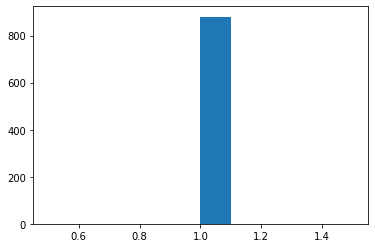

In [51]:
#Plotting the histogram of the test score
plt.hist(Y_pred)

In [52]:
predicted=Y_pred                             #Predicted value
real=Y_test                                  #Real value
Precision_sum=0
Recall_sum=0
Accuracy_sum=0

for i in range(len(classes2)):
  print("For class :",classes2[i])
  TP=((predicted==i) & (real==i)).sum()        #True Positive
  TN=((predicted!=i) & (real!=i)).sum()        #True Negative
  FP=((predicted==i) & (real!=i)).sum()        #False Positive
  FN=((predicted!=i) & (real==i)).sum()        #False Negative

  P=TP+FN                                      #Positives(real)
  N=TN+FP                                      #Negatives(real)

  Total=P+N                                    #Total tuples

  #Calculating all metrices
  Accuracy=(TP+TN)/Total
  Accuracy_sum+=Accuracy
  Sensitivity=TP/P
  Specificity=TN/N
  Precision=TP/(TP+FP)
  Precision_sum+=Precision
  Recall=TP/P
  Recall_sum+=Recall
  KS=(TP/P)-(FP/N) 
  F1=2*Precision*Recall/(Precision+Recall)

  print("TP:",TP,"TN:",TN,"FP:",FP,"FN:",FN,"P:",P,"N:",N,"Total:",Total)
  print("Accuracy    =",Accuracy)
  print("Sensitivity =",Sensitivity)
  print("Specificity =",Specificity)
  print("Precision   =",Precision)
  print("Recall      =",Recall)
  print("KS          =",KS)
  print("F1          =",F1)
  print()

#Global
Precision=Precision_sum/len(classes2)
Recall=Recall_sum/len(classes2)
Accuracy=Accuracy_sum/len(classes2)
F1=2*Precision*Recall/(Precision+Recall)

print("Global Metrics:")
print("Accuracy    =",Accuracy)
print("Precision   =",Precision)
print("Recall      =",Recall)
print("F1          =",F1)

For class : UNT
TP: 0 TN: 775 FP: 0 FN: 105 P: 105 N: 775 Total: 880
Accuracy    = 0.8806818181818182
Sensitivity = 0.0
Specificity = 1.0
Precision   = nan
Recall      = 0.0
KS          = 0.0
F1          = nan

For class : TIN
TP: 775 TN: 0 FP: 105 FN: 0 P: 775 N: 105 Total: 880
Accuracy    = 0.8806818181818182
Sensitivity = 1.0
Specificity = 0.0
Precision   = 0.8806818181818182
Recall      = 1.0
KS          = 0.0
F1          = 0.9365558912386707

Global Metrics:
Accuracy    = 0.8806818181818182
Precision   = nan
Recall      = 0.5
F1          = nan


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:24: RuntimeWarning: invalid value encountered in long_scalars


In [53]:
print(classification_report(real,predicted,target_names=classes2))

              precision    recall  f1-score   support

         UNT       0.00      0.00      0.00       105
         TIN       0.88      1.00      0.94       775

    accuracy                           0.88       880
   macro avg       0.44      0.50      0.47       880
weighted avg       0.78      0.88      0.82       880



/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [54]:
#Prediction for an instance of the test dataset
i=2
X_test[i],classes2[Y_pred[i]],classes2[Y_test[i]]

('@USER @USER No one gives a shit and no one will miss her! Sorry @USER will! URL',
 'TIN',
 'TIN')

In [55]:
#Predicting the tweets
instance = df['tweet'][1]
print(instance)

instance_tf = tf2.transform([instance])
instance_tf_pd=pd.DataFrame(instance_tf.toarray(),columns=tf2.get_feature_names())
pred=svm2.predict(instance_tf_pd)

classes2[pred[0]],df['subtask_b'][1]

@USER @USER Go home you’re drunk!!! @USER #MAGA #Trump2020 👊🇺🇸👊 URL


('TIN', 'TIN')

**3rd** level classification starts here...

In [56]:
#Importing the dataset with the 3rd subtask
df3=df.loc[df["subtask_c"].notnull()]
df3.reset_index(drop=True,inplace=True)

In [57]:
#Sample dataset
df3.head()

,tweet,subtask_a,subtask_b,subtask_c
0,@USER @USER Go home you’re drunk!!! @USER #MAG...,OFF,TIN,IND
1,@USER Liberals are all Kookoo !!!,OFF,TIN,OTH
2,@USER was literally just talking about this lo...,OFF,TIN,GRP
3,@USER Canada doesn’t need another CUCK! We alr...,OFF,TIN,IND
4,@USER you are a lying corrupt traitor!!! Nobod...,OFF,TIN,IND


In [58]:
#Shape of the dataset
df3.shape

(3876, 4)

In [59]:
#Class counts
df3["subtask_c"].value_counts()

IND    2407
GRP    1074
OTH     395
Name: subtask_c, dtype: int64

In [60]:
#Input dataset 
X=df3["tweet"]

In [61]:
#Y represents the vector of 0,1,2 
#0 represents OTH,1 represents IND and 2 represents GRP
Y = (df3["subtask_c"]=="IND").astype(int)
Y2 = (df3["subtask_c"]=="GRP").astype(int)*2
Y+=Y2

In [62]:
#Class counts
Y.value_counts()

1    2407
2    1074
0     395
Name: subtask_c, dtype: int64

In [63]:
#Class vector
classes3=["OTH","IND","GRP"]

In [64]:
#Splitting the training and testing dataset
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=2)

In [65]:
#Resetting the indices of the split dataset
X_test=X_test.reset_index(drop=True)
Y_test=Y_test.reset_index(drop=True)
X_train=X_train.reset_index(drop=True)
Y_train=Y_train.reset_index(drop=True)

In [66]:
#Import CountVectorizer Library for feature extraction
tf3=CountVectorizer(analyzer=text_prepare,min_df=20,max_df=500)

In [67]:
#Fitting on training dataset and transforming dataset to get features in dataframe form
tf3.fit(X_train)

train_tf=tf3.transform(X_train)

X_train_tf=pd.DataFrame(train_tf.toarray(),columns=tf3.get_feature_names())

test_tf=tf3.transform(X_test)

X_test_tf=pd.DataFrame(test_tf.toarray(),columns=tf3.get_feature_names())

In [68]:
#Shape of the train and test dataset after transformation
X_train_tf.shape,X_test_tf.shape

((3100, 302), (776, 302))

In [69]:
#importing SVM classifier model
svm3=SVC(probability=True)

In [70]:
#Training the SVM on the training dataset
svm3.fit(X_train_tf,Y_train)

SVC(C=1.0, break_ties=False, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='scale', kernel='rbf',
    max_iter=-1, probability=True, random_state=None, shrinking=True, tol=0.001,
    verbose=False)

In [71]:
#Predicting the output based on the trained model
Y_pred=svm3.predict(X_test_tf)

In [72]:
#Checking the shape of the Y_pred vector and the Y_test vector
Y_pred.shape,Y_test.shape

((776,), (776,))

(array([625.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0., 151.]),
 array([1. , 1.1, 1.2, 1.3, 1.4, 1.5, 1.6, 1.7, 1.8, 1.9, 2. ]),
 <a list of 10 Patch objects>)

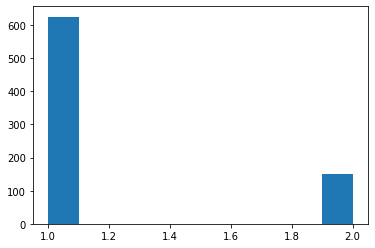

In [73]:
#Plotting the histogram of the test score
plt.hist(Y_pred)

In [74]:
predicted=Y_pred                             #Predicted value
real=Y_test                                  #Real value
Precision_sum=0
Recall_sum=0
Accuracy_sum=0

for i in range(len(classes3)):
  print("For class :",classes3[i])
  TP=((predicted==i) & (real==i)).sum()        #True Positive
  TN=((predicted!=i) & (real!=i)).sum()        #True Negative
  FP=((predicted==i) & (real!=i)).sum()        #False Positive
  FN=((predicted!=i) & (real==i)).sum()        #False Negative

  P=TP+FN                                      #Positives(real)
  N=TN+FP                                      #Negatives(real)

  Total=P+N                                    #Total tuples

  #Calculating all metrices
  Accuracy=(TP+TN)/Total
  Accuracy_sum+=Accuracy
  Sensitivity=TP/P
  Specificity=TN/N
  if TP+FP==0:
    Precision=0.0
  else:
    Precision=TP/(TP+FP)
  Precision_sum+=Precision
  Recall=TP/P
  Recall_sum+=Recall
  KS=(TP/P)-(FP/N) 
  F1=2*Precision*Recall/(Precision+Recall)

  print("TP:",TP,"TN:",TN,"FP:",FP,"FN:",FN,"P:",P,"N:",N,"Total:",Total)
  print("Accuracy    =",Accuracy)
  print("Sensitivity =",Sensitivity)
  print("Specificity =",Specificity)
  print("Precision   =",Precision)
  print("Recall      =",Recall)
  print("KS          =",KS)
  print("F1          =",F1)
  print()

#Global
Precision=Precision_sum/len(classes3)
Recall=Recall_sum/len(classes3)
Accuracy=Accuracy_sum/len(classes3)
F1=2*Precision*Recall/(Precision+Recall)

print("Global Metrics:")
print("Accuracy    =",Accuracy)
print("Precision   =",Precision)
print("Recall      =",Recall)
print("F1          =",F1)

For class : OTH
TP: 0 TN: 698 FP: 0 FN: 78 P: 78 N: 698 Total: 776
Accuracy    = 0.8994845360824743
Sensitivity = 0.0
Specificity = 1.0
Precision   = 0.0
Recall      = 0.0
KS          = 0.0
F1          = nan

For class : IND
TP: 451 TN: 119 FP: 174 FN: 32 P: 483 N: 293 Total: 776
Accuracy    = 0.7345360824742269
Sensitivity = 0.9337474120082816
Specificity = 0.4061433447098976
Precision   = 0.7216
Recall      = 0.9337474120082816
KS          = 0.33989075671817925
F1          = 0.8140794223826715

For class : GRP
TP: 103 TN: 513 FP: 48 FN: 112 P: 215 N: 561 Total: 776
Accuracy    = 0.7938144329896907
Sensitivity = 0.4790697674418605
Specificity = 0.9144385026737968
Precision   = 0.6821192052980133
Recall      = 0.4790697674418605
KS          = 0.39350827011565725
F1          = 0.5628415300546449

Global Metrics:
Accuracy    = 0.8092783505154638
Precision   = 0.46790640176600445
Recall      = 0.470939059816714
F1          = 0.4694178327462449


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:32: RuntimeWarning: invalid value encountered in double_scalars


In [76]:
print(classification_report(real,predicted,target_names=classes3))

              precision    recall  f1-score   support

         OTH       0.00      0.00      0.00        78
         IND       0.72      0.93      0.81       483
         GRP       0.68      0.48      0.56       215

    accuracy                           0.71       776
   macro avg       0.47      0.47      0.46       776
weighted avg       0.64      0.71      0.66       776



/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [77]:
#Prediction for an instance of the test dataset
i=0
X_test[i],classes3[Y_pred[i]],classes3[Y_test[i]]

("@USER @USER @USER John careful... liberals will attack you for thinking critically because the facts aren't on their side",
 'GRP',
 'GRP')

In [78]:
#Predicting the tweets at the third level of classification
instance = df['tweet'][1]
print(instance)

instance_tf = tf3.transform([instance])
instance_tf_pd=pd.DataFrame(instance_tf.toarray(),columns=tf3.get_feature_names())
pred=svm3.predict(instance_tf_pd)

classes3[pred[0]],df['subtask_c'][1]

@USER @USER Go home you’re drunk!!! @USER #MAGA #Trump2020 👊🇺🇸👊 URL


('IND', 'IND')

Combined testing at all the 3 levels

In [79]:
#Testing model with 3-level classification
def testing_model(instance,countvectorizer,model):
  instance_tf = countvectorizer.transform([instance])
  instance_tf_pd=pd.DataFrame(instance_tf.toarray(),columns=countvectorizer.get_feature_names())
  return model.predict(instance_tf_pd)

In [80]:
#Method to test an instance at all the 3 levels of classification.
def testing(instance):
  print(instance)
  #Level 1 prediction with SVM1
  pred=testing_model(instance,tf1,svm1)
  print(pred)
  print("level1:",classes1[pred[0]])
  #Level 2 prediction with SVM2
  pred=testing_model(instance,tf2,svm2)
  print(pred)
  print("level2:",classes2[pred[0]])
  #Level 3 prediction with SVM3
  pred=testing_model(instance,tf3,svm3)
  print(pred)
  print("level3:",classes3[pred[0]])

In [81]:
#Testing for an instance at index 1
testing(df['tweet'][1])

@USER @USER Go home you’re drunk!!! @USER #MAGA #Trump2020 👊🇺🇸👊 URL
[0]
level1: NOT
[1]
level2: TIN
[1]
level3: IND


In [82]:
#Output of the dataset instance at position 9
df['subtask_a'][9],df['subtask_b'][9],df['subtask_c'][9]

('OFF', 'TIN', 'IND')

In [83]:
#Testing custom input data
testing('I am a good boy')

I am a good boy
[0]
level1: NOT
[1]
level2: TIN
[1]
level3: IND


In [84]:
#Testing custom input data
testing('Bad people are very bad')

Bad people are very bad
[0]
level1: NOT
[1]
level2: TIN
[1]
level3: IND
